<a href="https://colab.research.google.com/github/FRJackson/hw/blob/main/5245HW5%E6%97%B6%E9%97%B4%E5%BA%8F%E5%88%97Q_learn%2CSarsa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import numpy as np  # 导入 numpy，用来处理数组和随机数

def eps_greedy_policy(state, q_table, eps=0.1):
    """
    From a given Q-table, select an action according to an epsilon-greedy policy.

    Parameters
    ----------
    state : int
        当前的状态索引（例如 0, 1, 2, ..., n_states-1）。
    q_table : np.ndarray
        Q 表，形状一般为 (n_states, n_actions)，
        q_table[s, a] 表示在状态 s 选择动作 a 的 Q 值。
    eps : float, optional
        epsilon，探索概率。默认 0.1，即 10% 的概率随机探索。

    Returns
    -------
    action : int
        根据 epsilon-greedy 策略选出的动作索引。
    """
    # 1. 从 Q 表中取出当前 state 对应的所有动作的 Q 值，得到形状为 (n_actions,) 的一行
    q_values = q_table[state]

    # 2. 获取动作空间大小（即这一行的长度）
    n_actions = q_values.shape[0]

    # 3. 生成一个 0 到 1 的随机数，如果小于 eps，就执行“探索”
    if np.random.rand() < eps:
        # 探索：在所有可能动作中随机选择一个动作
        action = np.random.randint(n_actions)
    else:
        # 开始“利用”：选择 Q 值最大的动作
        # 3.1 先算出最大的 Q 值
        max_q = np.max(q_values)

        # 3.2 找出所有 Q 值等于 max_q 的动作索引（可能有多个并列最优）
        best_actions = np.flatnonzero(q_values == max_q)

        # 3.3 在这些并列最优动作中随机选一个，避免永远选到第一个
        action = np.random.choice(best_actions)

    # 4. 返回最终选定的动作
    return action


In [29]:
# 构造一个简单的假的 Q 表：
# 假设有 3 个状态、4 个动作
dummy_q = np.array([
    [-1.0, -2.0, -3.0, -4.0],   # state 0
    [-5.0, -1.0, -1.0, -10.0],  # state 1
    [ 0.0,  0.0,  0.0,  0.0]    # state 2
])

state = 1  # 测试状态 1
eps = 0.2  # 20% 概率探索，80% 概率利用

actions_sampled = [eps_greedy_policy(state, dummy_q, eps) for _ in range(20)]
print(actions_sampled)


[np.int64(1), 2, np.int64(2), np.int64(1), 3, np.int64(1), np.int64(1), np.int64(2), np.int64(1), 2, np.int64(2), np.int64(1), 1, 0, np.int64(2), np.int64(2), np.int64(2), np.int64(1), np.int64(1), 0]


In [30]:
import numpy as np  # 导入 numpy 用来处理数组与数值运算

def q_learning(environment, nEpisodes=1, eps=0.1, alpha=0.1, discount=1.0):
    """
    使用 Q-learning 方法在给定环境上训练一个 Q 表。

    Parameters
    ----------
    environment : gym.Env
        强化学习环境，例如 gym.make('CliffWalking-v0') 创建的环境。
    nEpisodes : int, optional
        训练的 episode 数量。默认 1，作业中会用到 500。
    eps : float, optional
        epsilon-greedy 策略中的 epsilon，控制探索概率。默认 0.1。
    alpha : float, optional
        学习率 (step size)，范围一般在 (0, 1]。默认 0.1。
    discount : float, optional
        折扣因子 gamma，默认 1.0（本作业是 undiscounted 任务，所以设置为 1 也可以）。

    Returns
    -------
    q_table : np.ndarray
        学到的 Q 表，形状为 (n_states, n_actions)。
    numStepsArray : np.ndarray
        每个 episode 所走步数的整数数组，形状为 (nEpisodes,)。
    """
    # 1. 从环境中读取状态数与动作数（CliffWalking 是离散状态和离散动作）
    n_states = environment.observation_space.n
    n_actions = environment.action_space.n

    # 2. 初始化 Q 表为全 0，形状为 (n_states, n_actions)
    #    q_table[s, a] 表示在状态 s 采取动作 a 的当前估计 Q 值
    q_table = np.zeros((n_states, n_actions), dtype=float)

    # 3. 创建一个数组用来记录每个 episode 所走的步数
    numStepsArray = np.zeros(nEpisodes, dtype=int)

    # 4. 进行多轮训练：一共运行 nEpisodes 个 episode
    for episode in range(nEpisodes):
        # 4.1 重置环境，得到起始状态 state
        state = environment.reset()
        # 某些新版本 gym 会返回 (obs, info) 元组，这里做一下兼容
        if isinstance(state, tuple):
            state = state[0]

        done = False   # 标记当前 episode 是否结束
        steps = 0      # 记录本 episode 已经走了多少步

        # 4.2 在当前 episode 中循环，直到到达终止状态（done=True）
        while not done:
            # 4.2.1 使用 epsilon-greedy 策略从 Q 表中选出一个动作
            action = eps_greedy_policy(state, q_table, eps)

            # 4.2.2 在环境中执行这个动作，得到下一状态、奖励、是否结束等信息
            step_out = environment.step(action)

            # 兼容不同 gym 版本的返回值格式：
            # 旧版: next_state, reward, done, info
            # 新版(gymnasium): next_state, reward, terminated, truncated, info
            if len(step_out) == 4:
                next_state, reward, done, info = step_out
            else:
                next_state, reward, terminated, truncated, info = step_out
                done = terminated or truncated

            # 某些版本 reset/step 返回 (obs, info) 的 obs 也可能是元组，这里处理一下
            if isinstance(next_state, tuple):
                next_state = next_state[0]

            # 4.2.3 计算 Q-learning 的目标值 (TD target)
            #       target = r + gamma * max_a' Q(next_state, a')
            #       若已经终止，也可以令未来项为 0
            if done:
                # 终止状态：后续没有未来奖励，目标只等于即时奖励
                td_target = reward
            else:
                # 非终止：在 next_state 上找出最大 Q 值
                best_next_q = np.max(q_table[next_state])
                td_target = reward + discount * best_next_q

            # 4.2.4 计算 TD 误差： target - 当前 Q(s, a)
            td_error = td_target - q_table[state, action]

            # 4.2.5 按照 Q-learning 更新公式更新 Q(s, a)
            #       Q(s,a) ← Q(s,a) + alpha * (target - Q(s,a))
            q_table[state, action] += alpha * td_error

            # 4.2.6 把当前状态更新为下一状态，步数加 1
            state = next_state
            steps += 1

        # 4.3 当前 episode 结束后，记录该 episode 的步数
        numStepsArray[episode] = steps

    # 5. 所有 episode 训练完毕，返回最终 Q 表以及每个 episode 的步数
    return q_table, numStepsArray


In [31]:
import numpy as np  # 先导入 numpy

# ==== 兼容性补丁：为旧版 gym 补上 np.bool8 别名 ====
# 含义：如果当前 numpy 没有 bool8 这个属性，就把它指向现有的 np.bool_
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_


import gym  # 再导入 gym

# 创建 CliffWalking 环境
env = gym.make("CliffWalking-v0")

# 测试：运行我们之前写的 q_learning 函数
q_table_q, steps_q = q_learning(env, nEpisodes=10, eps=0.1, alpha=0.5, discount=1.0)

print("训练后的 Q 表形状：", q_table_q.shape)
print("每个 episode 步数：", steps_q)


训练后的 Q 表形状： (48, 4)
每个 episode 步数： [341 359  84 130  88  83  56  77  42  66]


In [32]:
import gym

env = gym.make("CliffWalking-v0")

# 先训练 10 个 episode 试试
q_table_q, steps_q = q_learning(env, nEpisodes=10, eps=0.1, alpha=0.5, discount=1.0)

print("训练后的 Q 表形状：", q_table_q.shape)
print("每个 episode 步数：", steps_q)


训练后的 Q 表形状： (48, 4)
每个 episode 步数： [422 129  84  88 169  67  81  52  51  80]


In [33]:
import numpy as np  # 导入 numpy，用来处理数组和数值运算

def sarsa(environment, nEpisodes=1, eps=0.1, alpha=0.1, discount=1.0):
    """
    使用 Sarsa 方法在给定环境上训练一个 Q 表。

    Parameters
    ----------
    environment : gym.Env
        强化学习环境，例如 gym.make('CliffWalking-v0') 创建的环境。
    nEpisodes : int, optional
        训练的 episode 数量。默认 1，作业中会用到 500。
    eps : float, optional
        epsilon-greedy 策略中的 epsilon，控制探索概率。默认 0.1。
    alpha : float, optional
        学习率 (step size)，范围一般在 (0, 1]。默认 0.1。
    discount : float, optional
        折扣因子 gamma，默认 1.0（本作业是 undiscounted 任务，所以设为 1 也可以）。

    Returns
    -------
    q_table : np.ndarray
        学到的 Q 表，形状为 (n_states, n_actions)。
    numStepsArray : np.ndarray
        每个 episode 所走步数的整数数组，形状为 (nEpisodes,)。
    """
    # 1. 从环境中读取状态数与动作数（CliffWalking 是离散状态和离散动作）
    n_states = environment.observation_space.n
    n_actions = environment.action_space.n

    # 2. 初始化 Q 表为全 0，形状为 (n_states, n_actions)
    #    q_table[s, a] 表示在状态 s 采取动作 a 的当前估计 Q 值
    q_table = np.zeros((n_states, n_actions), dtype=float)

    # 3. 创建一个数组用来记录每个 episode 所走的步数
    numStepsArray = np.zeros(nEpisodes, dtype=int)

    # 4. 进行多轮训练：一共运行 nEpisodes 个 episode
    for episode in range(nEpisodes):
        # 4.1 重置环境，得到起始状态 state
        state = environment.reset()
        # 某些新版本 gym 会返回 (obs, info) 元组，这里做一下兼容
        if isinstance(state, tuple):
            state = state[0]

        # 4.2 在起始状态上，先用 epsilon-greedy 策略选择一个初始动作
        action = eps_greedy_policy(state, q_table, eps)

        done = False   # 标记当前 episode 是否结束
        steps = 0      # 记录本 episode 已经走了多少步

        # 4.3 在当前 episode 中循环，直到到达终止状态（done=True）
        while not done:
            # 4.3.1 在环境中执行当前动作 action
            step_out = environment.step(action)

            # 兼容不同 gym 版本的返回值格式：
            # 旧版: next_state, reward, done, info
            # 新版(gymnasium): next_state, reward, terminated, truncated, info
            if len(step_out) == 4:
                next_state, reward, done, info = step_out
            else:
                next_state, reward, terminated, truncated, info = step_out
                done = terminated or truncated

            # 某些版本会把 next_state 包在 (obs, info) 里，这里处理一下
            if isinstance(next_state, tuple):
                next_state = next_state[0]

            # 4.3.2 如果还没结束，就在 next_state 上再选一个动作 next_action
            if not done:
                next_action = eps_greedy_policy(next_state, q_table, eps)
                # Sarsa 的目标值：使用“真正要走的下一步动作”的 Q 值
                td_target = reward + discount * q_table[next_state, next_action]
            else:
                # 如果已经终止，则未来没有更多奖励，目标等于即时奖励
                next_action = None  # 这里设为 None 只是占位，不会再用到
                td_target = reward

            # 4.3.3 计算 TD 误差： target - 当前 Q(s, a)
            td_error = td_target - q_table[state, action]

            # 4.3.4 按照 Sarsa 更新公式更新 Q(s, a)
            #       Q(s,a) ← Q(s,a) + alpha * (target - Q(s,a))
            q_table[state, action] += alpha * td_error

            # 4.3.5 把当前状态、动作更新为下一步的状态和动作，步数加 1
            state = next_state
            if not done:
                action = next_action  # 只有未结束时才更新为 next_action
            steps += 1

        # 4.4 当前 episode 结束后，记录该 episode 的步数
        numStepsArray[episode] = steps

    # 5. 所有 episode 训练完毕，返回最终 Q 表以及每个 episode 的步数
    return q_table, numStepsArray


In [34]:
import gym

env = gym.make("CliffWalking-v0")

q_table_sarsa, steps_sarsa = sarsa(env, nEpisodes=10, eps=0.1, alpha=0.5, discount=1.0)

print("Sarsa 训练后的 Q 表形状：", q_table_sarsa.shape)
print("Sarsa 每个 episode 步数：", steps_sarsa)


Sarsa 训练后的 Q 表形状： (48, 4)
Sarsa 每个 episode 步数： [495 198 105  57  50  78  69  54  60  96]


In [35]:
import gym          # 导入 gym，用来创建 CliffWalking 环境
import numpy as np  # 导入 numpy，后面画图要用到 np.arange

# ===== 1. 创建 CliffWalking 环境 =====
env = gym.make("CliffWalking-v0")  # 创建一个 CliffWalking-v0 的环境实例

# ===== 2. 设置一些超参数（可以后面自己改着玩）=====
n_episodes = 500   # 训练的 episode 数量，这里按题目要求用 500
eps = 0.1          # epsilon-greedy 的探索概率
alpha = 0.5        # 学习率：更新 Q 值时“走多大一步”
discount = 1.0     # 折扣因子 gamma，这个任务是 undiscounted，所以设为 1.0

# ===== 3. 训练 Q-learning 智能体 =====
# 调用我们在 (b) 写好的 q_learning 函数
q_table_q, steps_q = q_learning(
    environment=env,        # 使用刚刚创建好的环境
    nEpisodes=n_episodes,   # 训练 500 个 episode
    eps=eps,                # 使用上面设定的 epsilon
    alpha=alpha,            # 使用上面设定的学习率
    discount=discount       # 使用上面设定的折扣因子
)

# ===== 4. 重新创建一个环境，用来训练 Sarsa 智能体 =====
# 这样做是为了“干净一点”，不和上面的 env 混在一起
env_sarsa = gym.make("CliffWalking-v0")

# 调用我们在 (c) 写好的 sarsa 函数
q_table_s, steps_s = sarsa(
    environment=env_sarsa,  # 使用新的环境实例
    nEpisodes=n_episodes,   # 同样训练 500 个 episode
    eps=eps,                # 同样的 epsilon，方便比较
    alpha=alpha,            # 同样的学习率
    discount=discount       # 同样的折扣因子
)

# ===== 5. 打印一下形状，做一个简单检查 =====
print("Q-learning 得到的 Q 表形状:", q_table_q.shape)
print("Sarsa      得到的 Q 表形状:", q_table_s.shape)
print("Q-learning 每个 episode 的步数数组长度:", len(steps_q))
print("Sarsa      每个 episode 的步数数组长度:", len(steps_s))


Q-learning 得到的 Q 表形状: (48, 4)
Sarsa      得到的 Q 表形状: (48, 4)
Q-learning 每个 episode 的步数数组长度: 500
Sarsa      每个 episode 的步数数组长度: 500


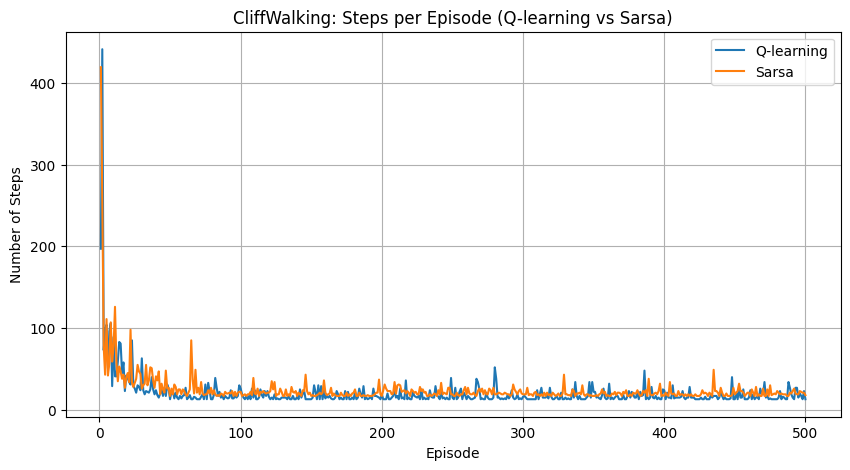

In [36]:
import matplotlib.pyplot as plt  # 导入 matplotlib 的 pyplot 子模块，用来画图

# ===== 1. 生成 x 轴：1, 2, ..., 500 这些 episode 编号 =====
episodes = np.arange(1, n_episodes + 1)  # 形状为 (500,)，从 1 到 500

# ===== 2. 创建画布 =====
plt.figure(figsize=(10, 5))  # 创建一个图像，宽 10，高 5（单位是英寸）

# ===== 3. 画出 Q-learning 每个 episode 的步数曲线 =====
plt.plot(
    episodes,      # x 轴：第几个 episode
    steps_q,       # y 轴：该 episode 所走的步数
    label="Q-learning"  # 图例名称
)

# ===== 4. 画出 Sarsa 每个 episode 的步数曲线 =====
plt.plot(
    episodes,      # x 轴同样是 episode 编号
    steps_s,       # y 轴：Sarsa 的步数
    label="Sarsa"  # 图例名称
)

# ===== 5. 添加坐标轴标签和标题 =====
plt.xlabel("Episode")                 # x 轴名字：Episode
plt.ylabel("Number of Steps")        # y 轴名字：Number of Steps
plt.title("CliffWalking: Steps per Episode (Q-learning vs Sarsa)")  # 图像标题

# ===== 6. 添加图例和网格 =====
plt.legend()      # 显示图例，区分两条线
plt.grid(True)    # 显示网格线，方便看趋势

# ===== 7. 显示图像 =====
plt.show()        # 在输出中画出这张图


In [37]:
import numpy as np  # 确保已经导入 numpy

def greedy_policy(state, q_table):
    """
    从 Q 表中按“纯贪心”策略选动作：总是选 Q 值最大的动作。
    如果有多个动作并列最大，就在它们中随机挑一个。
    """
    # 1. 取出当前状态这一行的所有 Q 值
    q_values = q_table[state]

    # 2. 找到最大的 Q 值
    max_q = np.max(q_values)

    # 3. 找出所有等于 max_q 的动作索引（可能有并列）
    best_actions = np.flatnonzero(q_values == max_q)

    # 4. 在并列最优的动作中随机选择一个
    action = np.random.choice(best_actions)

    # 5. 返回选择的动作
    return action


In [38]:
def play_one_episode(environment, q_table):
    """
    让一个 agent 在给定环境中跑一整局（从起点到终点），
    策略是：对每个状态都用 greedy_policy 从 Q 表里选动作。
    返回：这局用了多少步，以及这一局的总奖励。
    """
    # 1. 重置环境，拿到起始状态
    state = environment.reset()
    # 兼容有些 gym 返回 (obs, info) 的情况
    if isinstance(state, tuple):
        state = state[0]

    done = False        # 是否结束
    steps = 0           # 记录走了多少步
    total_reward = 0.0  # 记录这一整局的总奖励

    # 2. 一直循环，直到到达终点（或 episode 结束）
    while not done:
        # 2.1 在当前状态下，用贪心策略从 Q 表里选动作
        action = greedy_policy(state, q_table)

        # 2.2 在环境里执行这个动作
        step_out = environment.step(action)

        # 兼容旧版和新版 gym 的返回格式
        if len(step_out) == 4:
            next_state, reward, done, info = step_out
        else:
            next_state, reward, terminated, truncated, info = step_out
            done = terminated or truncated

        # 兼容 next_state 也可能是 (obs, info) 的情况
        if isinstance(next_state, tuple):
            next_state = next_state[0]

        # 2.3 把这一步得到的奖励加进总奖励
        total_reward += reward

        # 2.4 更新当前状态，步数 +1
        state = next_state
        steps += 1

    # 3. 整局结束，返回步数和总奖励
    return steps, total_reward


In [39]:
import gym  # 确保 gym 已经导入，并且前面有 bool8 的小补丁

# 为了公平起见，各自用一个新的环境来评估
env_eval_q = gym.make("CliffWalking-v0")
env_eval_s = gym.make("CliffWalking-v0")

# 让 Q-learning 学到的策略跑一局（贪心，不再探索）
steps_q_eval, reward_q_eval = play_one_episode(env_eval_q, q_table_q)

# 让 Sarsa 学到的策略跑一局（贪心，不再探索）
steps_s_eval, reward_s_eval = play_one_episode(env_eval_s, q_table_s)

print("Q-learning agent: 步数 =", steps_q_eval, ", 总奖励 =", reward_q_eval)
print("Sarsa agent:      步数 =", steps_s_eval, ", 总奖励 =", reward_s_eval)


Q-learning agent: 步数 = 13 , 总奖励 = -13.0
Sarsa agent:      步数 = 17 , 总奖励 = -17.0


### **(f) Evaluation of the learned policies**

Using the learned Q-tables and a greedy policy (no exploration), the two agents
were evaluated for one episode each.

- **Q-learning agent:** 13 steps, total reward = -13  
- **Sarsa agent:** 17 steps, total reward = -17  

The Q-learning agent reached the goal in fewer steps.  
This is expected because Q-learning (an off-policy TD method) uses  
\(\max_{a'}Q(s', a')\) when updating, so it tends to learn a shorter but
riskier path that goes close to the cliff.

Sarsa, as an on-policy method, updates using the action it actually takes,
so it tends to learn a safer route that stays farther away from the cliff.
As a result, it usually requires slightly more steps to reach the goal.

**Conclusion:**  
Q-learning learns a shorter path, while Sarsa learns a safer (but longer)
path. Both agents successfully learned reasonable strategies.
